## Adaptive Filters

In this notebook, we will expand upon our previous Wiener filter notebook (Lec. 8) and implement the same filter using an adaptive framework. We will use echo-cancelling as the application to demonstrate how to design these adaptive filters.

Written by: Randall Ali (randall.ali@esat.kuleuven.be)


Firstly let us import several of the packages we will need. If these packages are not available on your machine, you will have to install them first. 

In [1]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML('<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.'))

### Echo-Cancellation

Let us consider the following echo-canceller block diagram that we discussed during the lecture. In the following we will simulate a very simplified condition of what happens on the near-end room.

![title](img/echo_canceller.jpg)

Let us firstly record ourselves speaking, i.e. the signal $v(t)$.



In [2]:
# Recording our speech
T = 4     # recording time (s)
fs = 8000 # sampling freq (Hz)
t = np.arange(0, T, 1/fs)

print ('recording speech ...')
v = sd.rec(T*fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')


recording speech ...
finished recording


Data shape:  (32000, 1)
Recorded Signal:


<IPython.core.display.Javascript object>


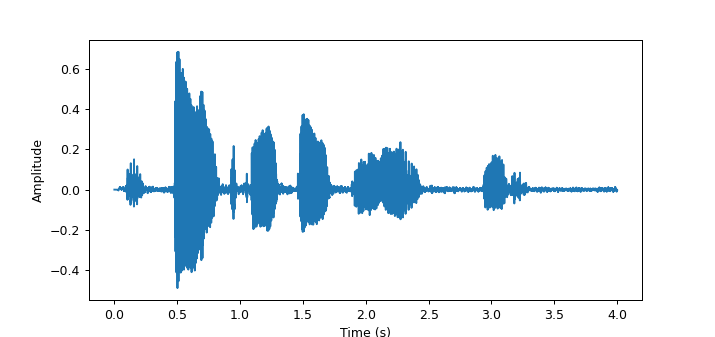

Text(0, 0.5, 'Amplitude')

In [3]:
# Plotting
print("Data shape: ", v.shape)
print("Recorded Signal:")
IPython.display.display(Audio(v.T, rate=fs))

fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,v, label = 'Desired')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')

### Propagation through the transmission channel

Okay so we have now recorded our speech with our microphone. Let us assume now that this speech signal has propagated through some transmission channel, the far-end room, and is now arriving to the loudspeaker. Let us simply represent this by some fixed delay of D samples. Hence we will simply consider that the signal, $x(t)$ is some delayed version of $v(t)$ (our speech) that was captured by the microphone. 

<IPython.core.display.Javascript object>


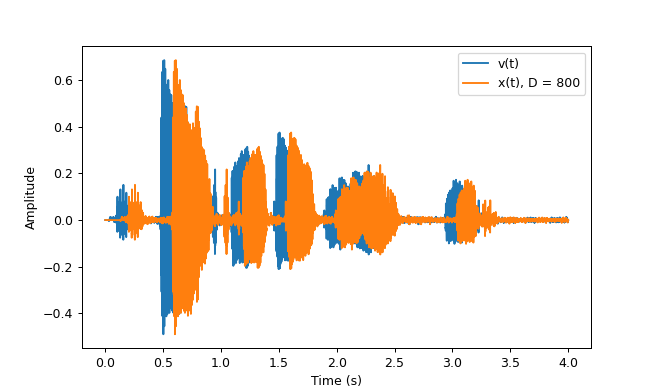

In [4]:
# We apply a delay to our speech signal.

t_delay = 0.1                 # Delay in milli-seconds (ms)
D = int(np.round(t_delay*fs)) # Number of samples of delay.
x = np.roll(v,D) # circular shift of the speech signal we recorded
x[0:D] = 0 # zero out the first D samples.


fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,v, label = 'v(t)')
axes.plot(t,x, label = 'x(t), D = '+str(D))
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


### Playing the signal through the loudspeaker

We now have $x(t)$, so let's play this through our loudspeaker and capture it again with our microphone. This now represents the speech signal being filtered by the transmission path between the loudspeaker and the microphone (F). Note that this is not simply a delay as the sound will also be subject to reflections from nearby surfaces. This will now allow us to obtain the signal $u(t)$.

In [5]:
# Use autoplay to play generated signal
print('Signal x to play: ')
IPython.display.display(Audio(x.T, rate=fs,autoplay=True,normalize=False)) # play autoplay signal to record

print ('recording...')
u = sd.rec(T*fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')



Signal x to play: 


recording...
finished recording


u(t):


<IPython.core.display.Javascript object>


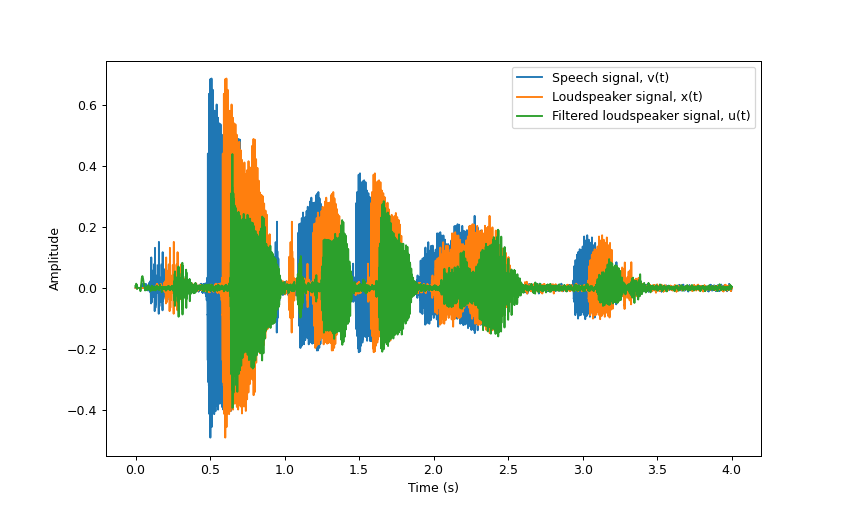

Speech Signal, v(t):


Echo Signal, y(t):


<IPython.core.display.Javascript object>


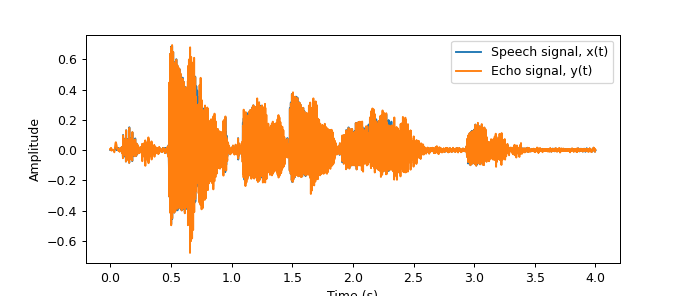

In [6]:
y_echo = v + u # This is our echo signal
print("u(t):")
IPython.display.display(Audio(u.T, rate=fs))
fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,v, label = 'Speech signal, v(t)')
axes.plot(t,x, label = 'Loudspeaker signal, x(t)')
axes.plot(t,u, label = 'Filtered loudspeaker signal, u(t)')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


print("Speech Signal, v(t):")
IPython.display.display(Audio(v.T, rate=fs))
print("Echo Signal, y(t):")
IPython.display.display(Audio(y_echo.T, rate=fs))

fig, axes = plt.subplots(figsize=(4, 2)) 

axes.plot(t,v, label = 'Speech signal, x(t)')
axes.plot(t,y_echo, label = 'Echo signal, y(t)')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()

### Estimating the Filters

We have successfully simulated the echo scenario which can occur at the near-end room.
Our goal now is to estimate the filter, F, from the loudspeaker to the microphone. This estimate will then be used to filter $x(t)$ and subsequently subtracted from our microphone signal to remove the echo. 

In order to focus on the process of designing the adaptive filters, let us make another simplification. 
Let us assume that $v(t) = 0$, so that $y(t) = u(t)$. Of course this is not a realistic assumption, but let's make it anyways and carry through with the procedure. We can then see the difference in performance if we do not make this assumption.

With the above assumption, in Wiener filter terminology, we can now say that $x(t)$ is our input signal and $y(t)$ is our desired signal, which is in fact known in this case. So let's try to estimate the filter F in the following ways:

(i) Using a Wiener filter with all the input data

(ii) Using an RLS adaptive filter

(iii) Using an LMS adaptive filter.

#### (i) Wiener Filter

Let's start with (i) Wiener Filter that we have previously encountered. See the python notebook on Lec. 8 for details on the Wiener filter. The optimal Wiener filter will be given as follows (Note the difference in the variable names from Lec. 8!):
\begin{equation}
\mathbf{\hat{f}} = \mathbf{R}^{-1}_{xx} \mathbf{r}_{xy},
\end{equation}

where $\mathbf{\hat{f}}$ is the Wiener filter of P coefficients and also the estimate of F, $\mathbf{R}_{xx} = \mathbb{E} \{ \mathbf{x x}^{\mathit{T}} \}$ is the autocorrelation matrix of dimension $(P \times P)$, and $\mathbf{r}_{xy} = \mathbb{E} \{ \mathbf{x}y \}$ is the cross-correlation vector of dimension P. The elements of $\mathbf{R}_{xx}$ are given by the autocorrelation function, $r_{xy}(k) = \mathbb{E} \{x(m) x(m+k) \}$ for the m$^{th}$ sample at lag k.

We compute $r_{xx}(k)$ and $r_{xy}(k)$ as follows:

\begin{align}
r_{xx}(k) &= \frac{1}{N} \sum_{m=0}^{N-1} x(m) x(m+k) \\
r_{xy}(k) &= \frac{1}{N} \sum_{m=0}^{N-1} x(m) y(m+k)
\end{align}

These values are then substituted into the equations above to solve for the Wiener filter. 

Input, x(t):


Echo signal, y(t):


Echo Estimate, y_hat:


Error signal, error:


MSE = 0.004751225302038359


<IPython.core.display.Javascript object>


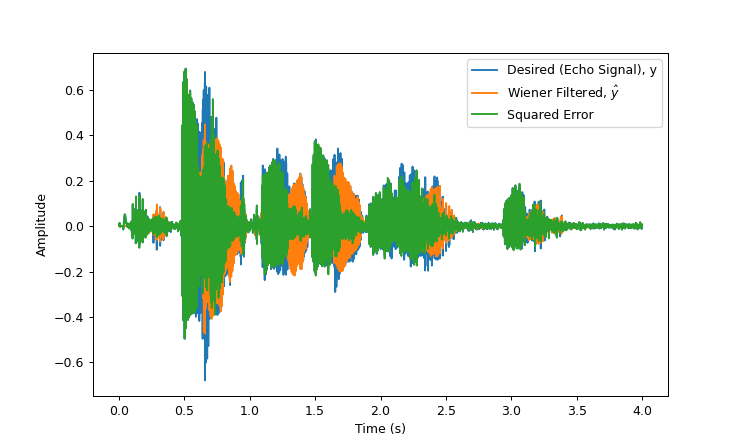

In [16]:
# Assumption to set v(t) = 0, hence y = u:
# y = u.copy()  # Desired signal
y = y_echo  # Without assumption that v = 0. Uncomment this to observe the effect on the performance
N = len(x)

# Select a value for P - number of Wiener filter coefficients
P = 500

# The approach to doing the computations of ryy and ryx is as follows.
# For each time lag, k:
#     1. Advance the appropriate signal by lag k - this will be done using a circular shift
#     2. Zero out last k circularly shifted samples
#     3. Then perform the sum as an inner product between the unshifted and shifted version and avg.

rxx = np.zeros([P,1])
rxy = np.zeros([P,1])

for k in range(P):

    y_lag = np.roll(y,-k) # circular shift, note the -k here, it means we are advancing, i.e. (m+k) sample
    x_lag = np.roll(x,-k) 
    
    if k > 0:
        y_lag[-k:] = 0       # zero out last k values
        x_lag[-k:] = 0       
    
        
    rxx[k,0] = (1/N)*x_lag.T@x  # Inner products and average
    rxy[k,0] = (1/N)*y_lag.T@x
    
    
# Create autocorrelation matrix Rxx
row1 = rxx.T  # first row in toeplitz matrix
col1 = rxx # first column in toeplitz matrix
Rxx = sp.linalg.toeplitz(col1, row1)  # Toeplitz matrix

# Solve the system of linear equations
# Use scipy.linalg.solve for solving systems of eqns
f_hat = sp.linalg.solve(Rxx, rxy, assume_a='sym')  # Estimate of echo path from loudspeaker to microphone

# Filter x with this estimate:
# Create toeplitz matrix for X
row1 = np.r_[x[0], np.zeros(P-1)]  # first row in toeplitz matrix
col1 = np.r_[x] # first column in toeplitz matrix
X = sp.linalg.toeplitz(col1, row1)  # Toeplitz matrix
y_hat = X@f_hat   # echo estimate
error = (y-y_hat) # error between true echo signal and estimate
MSE = (1/N)*np.sum(error**2) # Mean-sqaured error between both signals


print("Input, x(t):")
IPython.display.display(Audio(x.T, rate=fs,normalize=False))

print("Echo signal, y(t):")
IPython.display.display(Audio(y.T, rate=fs,normalize=False))

print("Echo Estimate, y_hat:")
IPython.display.display(Audio(y_hat.T, rate=fs,normalize=False))

print("Error signal, error:")
IPython.display.display(Audio(error.T, rate=fs,normalize=False))

print("MSE = "+str(MSE))


fig, axes = plt.subplots(figsize=(4, 2)) 

# axes.plot(t,x,label='Input')
axes.plot(t,y,label='Desired (Echo Signal), y')
axes.plot(t,y_hat,label='Wiener Filtered, $\hat{y}$')
axes.plot(t,error,label='Squared Error')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


#### (ii) RLS filter

Cool! So that worked, we were able to successfully model the echo-path F, use it to filter $x(t)$, and cancel the echo. However, with the Wiener filter, we assumed that we had access to all of the data and were able to build the correlation matrix and cross-correlation vector accordingly. This may not always be the case and we may only have a certain number of samples available at a particular time, such as in a real-time scenario. For such cases, we would then need to estimate the filter in an adaptive manner. Let's firstly try the RLS filter.

Recall the algorithm, as it pertains to our notation. $\Phi_{xx} = \mathbf{R_{xx}}^{-1}$

Initialisation: $\Phi_{xx}(0) = \delta \mathbf{I}, \mathbf{{f}}(0) = 0$  
For m = 1, 2, ...  

1. Adaption gain: $\mathbf{k}(m) = \frac{\lambda^{-1} \Phi_{xx}(m-1) \mathbf{x}(m)}{1 + \lambda^{-1} \mathbf{x}^{T}(m)\Phi_{xx}(m-1) \mathbf{x}(m)}$   


2. Error signal: $e(m) = y(m) - \mathbf{f}^{T}(m-1) \mathbf{x}(m)$  


3. Filter coefficient update: $\mathbf{f}(m) = \mathbf{f}(m-1) + \mathbf{k}e(m) $   


4. Inverse autocorr. matrix update: $\Phi_{xx}(m) = \lambda^{-1} \Phi_{xx}(m-1) + \lambda^{-1} \mathbf{x}^{T}(m)\Phi_{xx}(m-1)$


In [10]:
# Initialistion:

delta = 1e-5
Phi_xx = delta*np.eye(P)
f_rls = np.zeros([P,len(x)])
lambda_ff = 0.999 # Forgetting factor - Change this to observe how the filter converges.
yhat_rls = np.zeros([len(x),1])
e_rls = np.zeros([len(x),1])


# We start the for loop from P+1 so that we have enough previous samples m-(P-1).
# We could also start from m = 1, and then set initial values of x(m) for m < 0 equal to zero.
# Since x has a delay already in it, it will not make much of a difference.

for m in np.arange(P+1,len(x),1): 
    
    # P samples in x
    x_tmp = x[m-(P-1):m+1] # We need the m+1 here because of python's convention to select values up to the last index-1
    x_P = x_tmp[::-1] # reverse the columns so x(m) is the first element
    
    # 1. Compute the adaptation gain
    k_num = (1/lambda_ff)*(Phi_xx@x_P)  # This is the previous Phi_xx at (m-1), but current x(m)
    k_den = 1 + (1/lambda_ff)*(x_P.T@Phi_xx@x_P)
    k_gain = k_num/k_den
    
    # 2. Error signal
    yhat_rls[m] = (f_rls[:,m-1].T)@x_P # this will be our filtered signal
    e_rls[m] = y[m] -  yhat_rls[m]
    
    # 3. Update filter coefficients
    f_rls[:,m] = f_rls[:,m-1] + k_gain@e_rls[m]

    # 4. Update the Inverse autocorrelation matrix
    Phi_xx = (1/lambda_ff)*(Phi_xx) - (1/lambda_ff)*(k_gain@x_P.T@Phi_xx)
    
    

Input, x(t):


Echo Signal, y(t):


Echo Estimate, $\hat{y}(t)$:


Error signal using RLS, error:


MSE from Wiener Filter= 0.00011503728703821949
MSE from RLS= 0.0004260491635238533


<IPython.core.display.Javascript object>


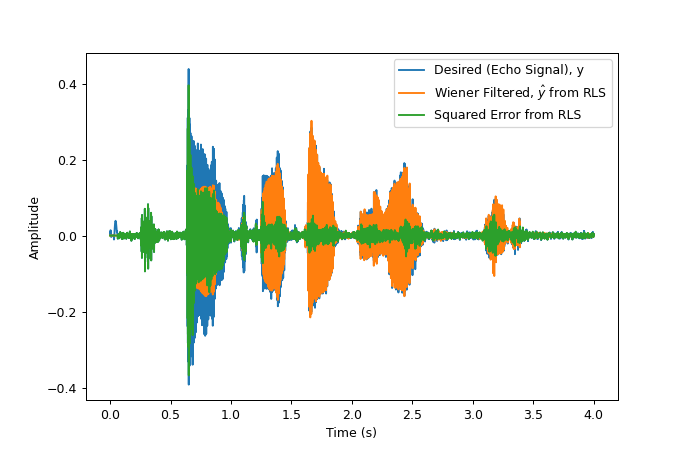

<IPython.core.display.Javascript object>


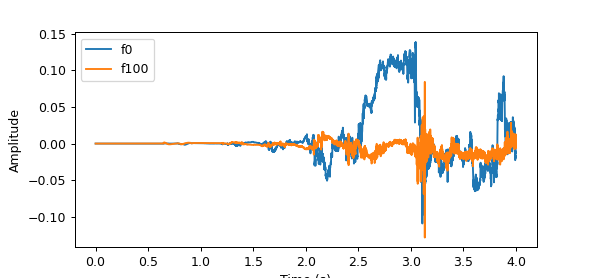

In [11]:
# Let's plot the results to see what that gave us... (hope for the best...)
MSE_rls = (1/N)*np.sum(e_rls**2) # Mean-sqaured error between both signals

print("Input, x(t):")
IPython.display.display(Audio(x.T, rate=fs,normalize=False))

print("Echo Signal, y(t):")
IPython.display.display(Audio(y.T, rate=fs,normalize=False))

print("Echo Estimate, $\hat{y}(t)$:")
IPython.display.display(Audio(yhat_rls.T, rate=fs,normalize=False))

print("Error signal using RLS, error:")
IPython.display.display(Audio(e_rls.T, rate=fs,normalize=False))

print("MSE from Wiener Filter= "+str(MSE))
print("MSE from RLS= "+str(MSE_rls))

fig, axes = plt.subplots(figsize=(4, 2)) 

# axes.plot(t,x,label='Input')
# axes.plot(t,x_hat,label='Wiener Filtered')
axes.plot(t,y,label='Desired (Echo Signal), y')
axes.plot(t,yhat_rls,label='Wiener Filtered, $\hat{y}$ from RLS')
axes.plot(t,e_rls,label='Squared Error from RLS')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


# We can also plot the filter coefficients
fig, axes = plt.subplots(figsize=(4, 2)) 
axes.plot(t,f_rls[0,:],label='f0')
axes.plot(t,f_rls[100,:],label='f100')
# axes.plot(t,yhat_rls,label='Wiener Filtered, $\hat{y}$ from RLS')
# axes.plot(t,e_rls,label='Squared Error from RLS')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


#### (iii) LMS filter

So that also worked! yay! I hope you messed around with the forgetting factor to see the effect of it. 
Alright, so let's implement the final filter - the least mean squares (LMS) filter, which should be some P times faster than the LMS

Recall the algorithm, as it pertains to our notation.

Initialisation: Set a value for step size $\mu$, $\mathbf{{f}}(0) = 0$  
For m = 0, 1, 2, ...  
  
1. Error signal with old filter: $e(m) = y(m) - \mathbf{f}^{T}(m) \mathbf{x}(m)$   


2. Filter coefficient update: $\mathbf{f}(m+1) = \mathbf{f}(m) + \mu \mathbf{x}(m)e(m) $   


3. Update Error signal with new filter: $e(m) = y(m) - \mathbf{f}^{T}(m+1) \mathbf{x}(m)$


In [17]:
# Initialisation

mu = 1e-2 # Step size - change the value of this to see the effect
f_lms = np.zeros([P,len(x)])
yhat_lms = np.zeros([len(x),1])
e_lms = np.zeros([len(x),1])
# e_old = np.zeros([len(x),1])


# We start the for loop from P+1 so that we have enough previous samples m-(P-1).
# We could also start from m = 1, and then set initial values of x(m) for m < 0 equal to zero.
# Since x has a delay already in it, it will not make much of a difference.

for m in np.arange(P+1,len(x)-1,1): 
    
    # P samples in x
    x_tmp = x[m-(P-1):m+1] # We need the m+1 here because of python's convention to select values up to the last index-1
    x_P = x_tmp[::-1] # reverse the columns so x(m) is the first element
    
    # 1. Error signal with old filter
    e_old = y[m] -  (f_lms[:,m].T)@x_P 
    
    # 2. Update filter coefficients
    f_lms[:,m+1] = f_lms[:,m] + mu*(x_P@e_old)

    # 3. Update the error signal with new updated filter
    yhat_lms[m] = (f_lms[:,m+1].T)@x_P 
    e_lms[m] = y[m] - yhat_lms[m]
    
    

Input, x(t):


Echo signal, y(t):


Echo Estimate, $\hat{y}(t)$:


Error signal using LMS, error:


MSE from Wiener Filter= 0.004751225302038359
MSE from RLS= 0.0004260491635238533
MSE from LMS= 0.0038824364617800135


<IPython.core.display.Javascript object>


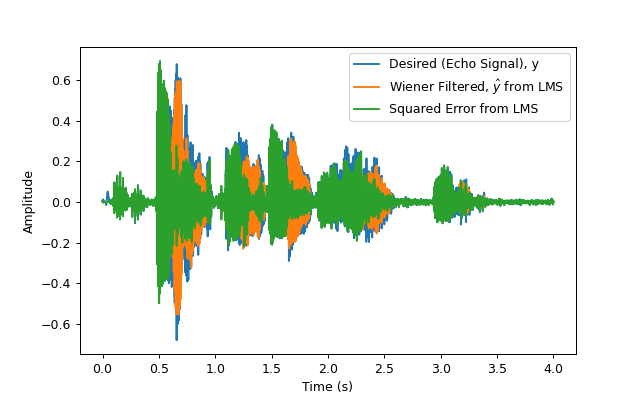

<IPython.core.display.Javascript object>


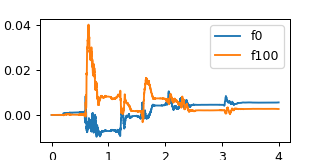

In [18]:
# Plotting results
MSE_lms = (1/N)*np.sum(e_lms**2) # Mean-sqaured error between both signals

print("Input, x(t):")
IPython.display.display(Audio(x.T, rate=fs,normalize=False))

print("Echo signal, y(t):")
IPython.display.display(Audio(y.T, rate=fs,normalize=False))

print("Echo Estimate, $\hat{y}(t)$:")
IPython.display.display(Audio(yhat_lms.T, rate=fs,normalize=False))

print("Error signal using LMS, error:")
IPython.display.display(Audio(e_lms.T, rate=fs,normalize=False))

print("MSE from Wiener Filter= "+str(MSE))
print("MSE from RLS= "+str(MSE_rls))
print("MSE from LMS= "+str(MSE_lms))

fig, axes = plt.subplots(figsize=(4, 2)) 

# axes.plot(t,x,label='Input')
# axes.plot(t,x_hat,label='Wiener Filtered')
axes.plot(t,y,label='Desired (Echo Signal), y')
axes.plot(t,yhat_lms,label='Wiener Filtered, $\hat{y}$ from LMS')
axes.plot(t,e_lms,label='Squared Error from LMS')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()


# We can also plot the filter coefficients
fig, axes = plt.subplots(figsize=(4, 2)) 
axes.plot(t,f_lms[0,:],label='f0')
axes.plot(t,f_lms[100,:],label='f100')
# axes.plot(t,yhat_rls,label='Wiener Filtered, $\hat{y}$ from RLS')
# axes.plot(t,e_rls,label='Squared Error from RLS')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
axes.legend()

### Confronting the assumptions

Okay so that's the end of this echo-canceller demo. At this stage we should have a better sppreciation of the Wiener filter and its adaptive counter parts, and the tuning parameters to make it all work well. We should also reflect on the assumptions we have made up to this point, namely that $v(t) = 0$. It is recommended to re-run the above codes, but now do not set $v(t) = 0$. Alternatively, let $y(t) = u(t) + v(t)$. How does the performance change? How can we improve things from here on... Much of the literature on echo-cancellation addresses such issues. 
